# Estimating COVID-19's $R_t$ with Rainier (ported from PYMC)

Grzegorz Kossakowski & Maciek Zdanowicz - May 5 (beta)

Model originally built by [Kevin Systrom](https://twitter.com/kevin) in `Realtime Rt mcmc.ipynb` notebook, ported to [Rainier](https://rainier.fit) with lots of help from [Avi Bryant](https://twitter.com/avibryant). Model comparison for European countries is in `Realtime Rt plots only.ipynb`.

This notebook requires [Almond](https://almond.sh) to run.

It's a work in progress.

In [1]:
import $ivy.`com.stripe::rainier-core:0.3.3`
import $ivy.`com.stripe::rainier-notebook:0.3.3`

import $ivy.$                               

import $ivy.$                                   

In [2]:
import com.stripe.rainier.compute._
import com.stripe.rainier.core._
import com.stripe.rainier.sampler._
import com.stripe.rainier.notebook._

import com.stripe.rainier.compute._

import com.stripe.rainier.core._

import com.stripe.rainier.sampler._

import com.stripe.rainier.notebook._

In [3]:
PPrint.register(repl)

In [4]:
import $ivy.`com.github.tototoshi::scala-csv:1.3.6`
import com.github.tototoshi.csv._
import java.io.File

import $ivy.$                                      

import com.github.tototoshi.csv._

import java.io.File

In [5]:
def time[R](block: => R): R = {
    val t0 = System.nanoTime()
    val result = block    // call-by-name
    val t1 = System.nanoTime()
    val timeMilis = ((t1 - t0) / 1e6).toInt
    println(s"Elapsed time: $timeMilis ms")
    result
}

defined function time

In [6]:
val countriesOnsetData = {
    val csvReader = CSVReader.open(new File("data/onset.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

countriesOnsetData: List[Map[String, String]] = List(
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-15",
    "Onset" -> "5.604302634759487"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-16",
    "Onset" -> "6.2397872854725644"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-17",
    "Onset" -> "7.1713802272177904"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-18",
    "Onset" -> "8.303601643703168"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-19",
    "Onset" -> "10.19796954314721"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-20",
    "Onset" -> "11.653372008701957"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-21",
    "Onset" -> "13.377568286197729"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-22",
...

In [7]:
import java.time.LocalDate
import java.time.chrono.ChronoLocalDate
// so comparisons work like max()
import scala.math.Ordering.Implicits._

def toDate(s: String): LocalDate =
    LocalDate.parse(s)

// we need to specify type parameter ChronoLocalDate (a super type of LocalDate) because
// that's what the comparison is defined for
countriesOnsetData.map(entry => toDate(entry("date"))).max[ChronoLocalDate]

import java.time.LocalDate

import java.time.chrono.ChronoLocalDate
// so comparisons work like max()

import scala.math.Ordering.Implicits._


defined function toDate
res6_4: LocalDate = 2020-05-22

In [8]:
val pdelayData = {
    val csvReader = CSVReader.open(new File("data/pdelay.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

pdelayData: List[Map[String, String]] = List(
  Map("index" -> "0", "pdelay" -> "0.007009910563210055"),
  Map("index" -> "1", "pdelay" -> "0.04205946337926034"),
  Map("index" -> "2", "pdelay" -> "0.05801305293691081"),
  Map("index" -> "3", "pdelay" -> "0.07034082668600435"),
  Map("index" -> "4", "pdelay" -> "0.07154943195552332"),
  Map("index" -> "5", "pdelay" -> "0.08581097413584723"),
  Map("index" -> "6", "pdelay" -> "0.07928450568044476"),
  Map("index" -> "7", "pdelay" -> "0.07493352671017646"),
  Map("index" -> "8", "pdelay" -> "0.07686729514140682"),
  Map("index" -> "9", "pdelay" -> "0.07904278462654098"),
  Map("index" -> "10", "pdelay" -> "0.0628474740149867"),
  Map("index" -> "11", "pdelay" -> "0.05148658448150834"),
  Map("index" -> "12", "pdelay" -> "0.04471839497220208"),
  Map("index" -> "13", "pdelay" -> "0.03843364757070341"),
  Map("index" -> "14", "pdelay" -> "0.028764805414551606"),
  Map("index" -> "15", "pdelay" -> "0.026347594875513657"),
  Map("index" -> "

In [9]:
val pdelay = pdelayData.collect { case m => m("pdelay").toDouble }
val cumulative_pdelay = pdelay.scanLeft(0.0)((x: Double, y: Double) => x+y).drop(1)

pdelay: List[Double] = List(
  0.007009910563210055,
  0.04205946337926034,
  0.05801305293691081,
  0.07034082668600435,
  0.07154943195552332,
  0.08581097413584723,
  0.07928450568044476,
  0.07493352671017646,
  0.07686729514140682,
  0.07904278462654098,
  0.0628474740149867,
  0.05148658448150834,
  0.04471839497220208,
  0.03843364757070341,
  0.028764805414551606,
  0.026347594875513657,
  0.019095963258399806,
  0.020546289581822575,
  0.011844331641285956,
  0.009427121102248005,
  0.0096688421561518,
  0.006526468455402465,
  0.004109257916364515,
  0.0036258158085569255,
  0.0029006526468455403,
  0.0036258158085569255,
  0.0019337684312303602,
  4.8344210780759005E-4,
  4.8344210780759005E-4,
  0.0,
  9.668842156151801E-4,
  2.4172105390379503E-4,
  4.8344210780759005E-4,
  7.251631617113851E-4,
  0.0014503263234227702,
  2.4172105390379503E-4,
  4.8344210780759005E-4,
  7.251631617113851E-4,
...
cumulative_pdelay: List[Double] = List(
  0.007009910563210055,
  0.049069373

In [10]:
def prepareDataForModel(xs: List[Long], pd: List[Double]): List[(Long,Double)] = {
    val cpd = pd.scanLeft(0.0)(_+_).tail
    val cpdPadded = List.fill(xs.size - pd.size)(1.0) ++ cpd.reverse
    // ensure that case numbers are always at least 1 so we avoid numerical issues involving 0
    // adding 1 across all counts doesn't change inputs in any material way
    // see the comment of `predictRt` method for the rationale
    xs.map(_+1).zip(cpdPadded)
}

defined function prepareDataForModel

Preparation of the other model

In [11]:
val L = (1L to 100L).toList
val pd = pdelay
val test = prepareDataForModel(L.takeRight(5), pd)

L: List[Long] = List(
  1L,
  2L,
  3L,
  4L,
  5L,
  6L,
  7L,
  8L,
  9L,
  10L,
  11L,
  12L,
  13L,
  14L,
  15L,
  16L,
  17L,
  18L,
  19L,
  20L,
  21L,
  22L,
  23L,
  24L,
  25L,
  26L,
  27L,
  28L,
  29L,
  30L,
  31L,
  32L,
  33L,
  34L,
  35L,
  36L,
  37L,
  38L,
...
pd: List[Double] = List(
  0.007009910563210055,
  0.04205946337926034,
  0.05801305293691081,
  0.07034082668600435,
  0.07154943195552332,
  0.08581097413584723,
  0.07928450568044476,
  0.07493352671017646,
  0.07686729514140682,
  0.07904278462654098,
  0.0628474740149867,
  0.05148658448150834,
  0.04471839497220208,
  0.03843364757070341,
  0.028764805414551606,
  0.026347594875513657,
  0.019095963258399806,
  0.020546289581822575,
  0.011844331641285956,
  0.009427121102248005,
  0.0096688421561518,
  0.006526468455402465,
  0.004109257916364515,
  0.0036258158085569255,
  0.0029006526468455403,
  0.0036258158085569255,
  0.0019337684312303602,
  4.8344210780759005E-4,
  4.8344210780759005E-4,
  0.0,

In [12]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
    override val iterations = 1000
}

samplerConfig: DefaultConfig{def massMatrixTuner(): com.stripe.rainier.sampler.IdentityMassMatrixTuner;def sampler(): com.stripe.rainier.sampler.HMCSampler} = ammonite.$sess.cmd11$Helper$$anon$1@764fac45

Define a function that we'll use to retry the call to Rainier's `predict` that fails occassionally. Fortunately, the failure can be easily detected and 1-2 retries solves the issue.

In [13]:
def retry[T](maxAttempts: Int, isSuccessful: T => Boolean)(f: => T): T = {
    var i = 0
    
    do {
        val res = f
        i = i + 1
        if (isSuccessful(res))
            return res
        println(s"WARN: Attempt[$i] failed. Retrying...")
    } while (i < maxAttempts)
    sys.error("Exceeded maximum number of retries")
}

defined function retry

Fixed the parameters for all distributions

In [14]:
case class RtModelEstimates(rts: Vec[Real], 
                            rtsEstimates: List[Seq[Double]], 
                            serialInterval: Real, 
                            serialIntervalEstimates: Seq[Double])

defined class RtModelEstimates

In [15]:

def predictRtOnsetLogProcess(onsetNumbers: List[Long], pdelay: List[Double]): (Vec[Real], List[Seq[Double]]) = {
    
    val data = prepareDataForModel(onsetNumbers, pdelay)
    
    val (model, rts) =  {
        val (onset, cum_pdelay) = data.unzip
        val serialInterval = Gamma(6,1.5).latent
        val logR0 = Normal(0, 1).latent
        val sigma = Exponential(10).latent
        val diffs = Laplace(0,sigma).latentVec(data.size)
        val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
        val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
            o_t/cp_t 
        }.zipWithIndex
        val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
            val lambda = infYest*cpd*((logRts(i).exp - 1)/serialInterval).exp
            Poisson(lambda)
        }
        (Model.observe(onset.drop(1), expectedToday), logRts.map(_.exp))
    }
    
    def detectFailedRun(trace: Trace): Boolean =
        // from: https://twitter.com/avibryant/status/1253049509128499201
        trace.diagnostics.map(_.rHat).max < 1.1
    
    val trace = retry(maxAttempts = 3, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 4)
    }
    
    rts -> trace.predict(rts)
}

defined function predictRtOnsetLogProcess

In [16]:
// direct (and faithful) translation of Systrom's MCMC model from
// Realtime Rt mcmc.ipynb up to different handling of this line
// mu = pm.math.maximum(.1, expected_today)
// my is the lambda of Poisson distribution that must be > 0.
// Kevin's solution is to take max(0.1, expected_today) to ensure
// that lambda > 0. However, `expected_today` is dependent only on input data and is not
// part of the model so we can ensure it's > 0 by fixing up the input data of the model.
// this is done in `prepareDataForModel`
def predictRt(onsetNumbers: List[Long], pdelay: List[Double], failedRunDetection: Boolean = true): RtModelEstimates = {
    
    val data = prepareDataForModel(onsetNumbers, pdelay)
    
    val (model, rts, serialInterval) = {
        val (onset, cum_pdelay) = data.unzip
        val serialInterval = Gamma(6,1/1.5).latent
        val sigma = Normal(0,0.03).latent.abs
        val Theta0 = Normal(0.1,0.1).latent
        val diffs = Laplace(0,sigma).latentVec(data.size) // Maybe normal would be better
        val ThetaT = Vec.from(diffs.toList.scanLeft(Theta0)(_ + _))
        val Rts = ThetaT.map(_*serialInterval + 1)
        val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
            o_t/cp_t 
        }.zipWithIndex
        val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
            val lambda = infYest * cpd * (ThetaT(i).exp)
            Poisson(lambda)
        }
        
        val obsModel = Model.observe(onset.drop(1), expectedToday)
        val trackSerialInterval = Model.track(Set(serialInterval))
        (obsModel.merge(trackSerialInterval), Rts, serialInterval)
    }
    
    def detectFailedRun(trace: Trace): Boolean =
        // from: https://twitter.com/avibryant/status/1253049509128499201
        !failedRunDetection || trace.diagnostics.map(_.rHat).max < 1.1
    
    val trace = retry(maxAttempts = 3, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 2)
    }

    RtModelEstimates(rts = rts, 
                 rtsEstimates = trace.predict(rts),
                 serialInterval = serialInterval,
                 serialIntervalEstimates = trace.predict(serialInterval))
}

defined function predictRt

In [17]:
case class RtsDistributionStats(means: Seq[(Int, Double)], hdpis: Seq[(Int, (Double, Double))])
def distributionStats(rts: Vec[Real], rtForecasts: List[Seq[Double]]): RtsDistributionStats = {
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val hdpis = 0.until(rts.size).map{i => (i, hdpi(rtForecasts.map(_(i))))}
    RtsDistributionStats(means, hdpis)
}

defined class RtsDistributionStats
defined function distributionStats

Chain 1 Complete : Iteration: 1000 (18ms) Acceptance rate: 0.89 E-BFMI: 0.73 Step size: 0.004 Total gradient evaluations: 2e+05 (93us) Total time: 36s

Chain 2 Complete : Iteration: 1000 (16ms) Acceptance rate: 0.85 E-BFMI: 0.64 Step size: 0.004 Total gradient evaluations: 2e+05 (78us) Total time: 34s

Elapsed time: 73723 ms


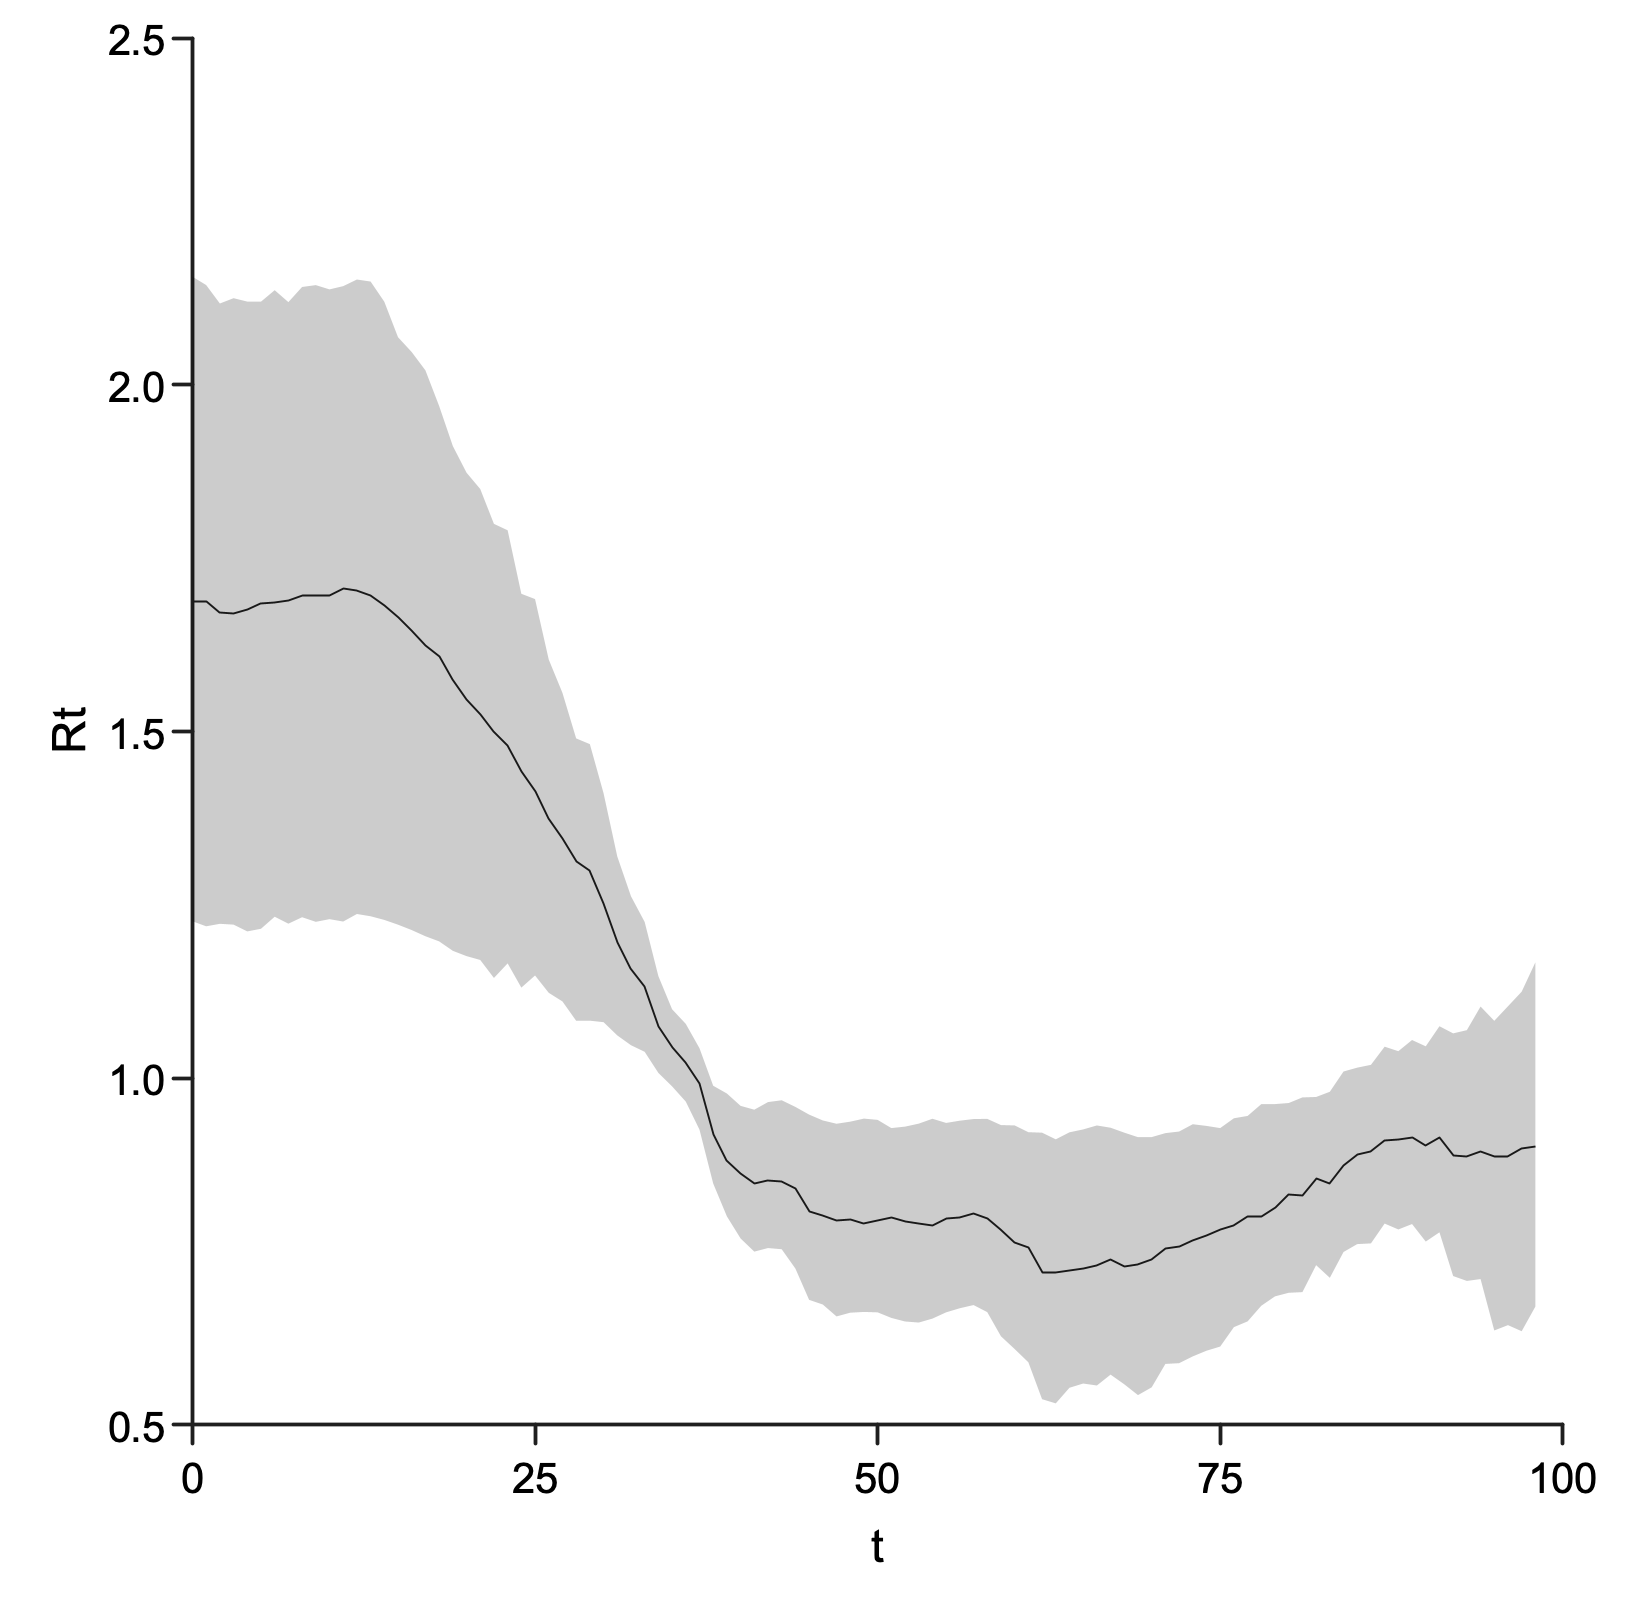

In [18]:
{{
    val countryName = "Spain"
    val onsetNumbers = countriesOnsetData.collect {
        case m if m("country") == countryName => m("Onset").toDouble.round
    }
    val RtModelEstimates(rts,estimates,_, _) = time { 
        val res = predictRt(onsetNumbers, pdelay, failedRunDetection = false)
        res
    }
    val RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
    show("t", "Rt", line(means), shade(hdpis))
}}

In [19]:
val countriesToPredict = countriesOnsetData.map(_("country")).toSet //smaller set: Seq("Poland", "France", "Italy", "Germany", "Czechia")

countriesToPredict: Set[String] = Set(
  "Poland",
  "Croatia",
  "Luxembourg",
  "Greece",
  "Spain",
  "Russia",
  "Estonia",
  "Czechia",
  "Romania",
  "Denmark",
  "Belgium",
  "Slovenia",
  "Malta",
  "Belarus",
  "Slovakia",
  "Finland",
  "Lithuania",
  "Sweden",
  "United_Kingdom",
  "Austria",
  "Latvia",
  "Italy",
  "Ireland",
  "Bulgaria",
  "Norway",
  "France",
  "Netherlands",
  "Switzerland",
  "Cyprus",
  "Germany",
  "Portugal",
  "Hungary"
)

In [20]:
import scala.util.Try

val countryStats: Map[String, Either[Throwable, RtsDistributionStats]] = {
    assert(countriesToPredict.toSet.subsetOf(countriesOnsetData.map(_("country")).toSet))
    val allStats = time {
        countriesToPredict.par.map { countryName =>
            val caseNumbers = countriesOnsetData.collect {
                case m if m("country") == countryName => m("Onset").toDouble.round
            }
            val possiblyFailed: Try[RtsDistributionStats] = Try { 
               val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = predictRt(caseNumbers, pdelay, failedRunDetection = false)
               val stats@RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
               println(s"$countryName [done]")
               stats
            }
            countryName -> possiblyFailed.toEither
        }.seq
    }
    allStats.toMap
}

Chain 1 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.80 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (212us) Total time: 0: 1:40

Chain 1 Complete : Iteration: 1000 (51ms) Acceptance rate: 0.85 E-BFMI: 0.69 Step size: 0.03 Total gradient evaluations: 2e+05 (234us) Total time: 0: 1:42

Chain 1 Complete : Iteration: 1000 (54ms) Acceptance rate: 0.85 E-BFMI: 0.64 Step size: 0.01 Total gradient evaluations: 2e+05 (241us) Total time: 0: 1:44

Chain 1 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.93 E-BFMI: 0.89 Step size: 0.003 Total gradient evaluations: 2e+05 (233us) Total time: 0: 1:40

Chain 1 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.82 E-BFMI: 0.75 Step size: 0.04 Total gradient evaluations: 2e+05 (247us) Total time: 0: 1:41

Chain 1 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.83 E-BFMI: 0.65 Step size: 0.04 Total gradient evaluations: 2e+05 (271us) Total time: 0: 1:40

Chain 1 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.80 E-BFMI: 0.64 Step size: 0.04 Total gradient evaluations: 2e+05 (322us) Total time: 0: 1:41

Chain 1 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.86 E-BFMI: 0.69 Step size: 0.02 Total gradient evaluations: 2e+05 (244us) Total time: 0: 1:41

Chain 1 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.77 E-BFMI: 0.77 Step size: 0.03 Total gradient evaluations: 2e+05 (259us) Total time: 0: 1:43

Chain 1 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.77 E-BFMI: 0.76 Step size: 0.01 Total gradient evaluations: 2e+05 (230us) Total time: 0: 1:42

Chain 1 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.88 E-BFMI: 0.69 Step size: 0.01 Total gradient evaluations: 2e+05 (306us) Total time: 0: 1:42

Chain 1 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.84 E-BFMI: 0.60 Step size: 0.03 Total gradient evaluations: 2e+05 (229us) Total time: 0: 1:43

Chain 1 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.89 E-BFMI: 0.67 Step size: 0.01 Total gradient evaluations: 2e+05 (221us) Total time: 0: 1:42

Chain 1 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.92 E-BFMI: 0.67 Step size: 0.003 Total gradient evaluations: 2e+05 (242us) Total time: 0: 1:45

Chain 1 Complete : Iteration: 1000 (53ms) Acceptance rate: 0.85 E-BFMI: 0.48 Step size: 0.02 Total gradient evaluations: 2e+05 (265us) Total time: 0: 1:43

Chain 1 Complete : Iteration: 1000 (51ms) Acceptance rate: 0.84 E-BFMI: 0.80 Step size: 0.006 Total gradient evaluations: 2e+05 (308us) Total time: 0: 1:42

Chain 2 Complete : Iteration: 1000 (48ms) Acceptance rate: 0.00 E-BFMI: 1.95 Step size: 0.004 Total gradient evaluations: 2e+05 (243us) Total time: 0: 1:36

Chain 2 Complete : Iteration: 1000 (48ms) Acceptance rate: 0.85 E-BFMI: 0.63 Step size: 0.02 Total gradient evaluations: 2e+05 (207us) Total time: 0: 1:36

Chain 2 Complete : Iteration: 1000 (49ms) Acceptance rate: 0.79 E-BFMI: 0.67 Step size: 0.04 Total gradient evaluations: 2e+05 (217us) Total time: 0: 1:36

Chain 2 Complete : Iteration: 1000 (49ms) Acceptance rate: 0.92 E-BFMI: 0.63 Step size: 0.01 Total gradient evaluations: 2e+05 (212us) Total time: 0: 1:36

Chain 2 Complete : Iteration: 1000 (49ms) Acceptance rate: 0.78 E-BFMI: 0.79 Step size: 0.04 Total gradient evaluations: 2e+05 (239us) Total time: 0: 1:36

Chain 2 Complete : Iteration: 1000 (51ms) Acceptance rate: 0.81 E-BFMI: 0.71 Step size: 0.04 Total gradient evaluations: 2e+05 (203us) Total time: 0: 1:37

Chain 2 Complete : Iteration: 1000 (49ms) Acceptance rate: 0.86 E-BFMI: 0.58 Step size: 0.01 Total gradient evaluations: 2e+05 (216us) Total time: 0: 1:36

Chain 2 Complete : Iteration: 1000 (49ms) Acceptance rate: 0.84 E-BFMI: 0.65 Step size: 0.01 Total gradient evaluations: 2e+05 (241us) Total time: 0: 1:36

Chain 2 Complete : Iteration: 1000 (52ms) Acceptance rate: 0.82 E-BFMI: 0.68 Step size: 0.03 Total gradient evaluations: 2e+05 (228us) Total time: 0: 1:37

Chain 2 Complete : Iteration: 1000 (50ms) Acceptance rate: 0.84 E-BFMI: 0.67 Step size: 0.01 Total gradient evaluations: 2e+05 (211us) Total time: 0: 1:36

Chain 2 Complete : Iteration: 1000 (50ms) Acceptance rate: 0.77 E-BFMI: 0.69 Step size: 0.005 Total gradient evaluations: 2e+05 (285us) Total time: 0: 1:36

Chain 2 Complete : Iteration: 1000 (50ms) Acceptance rate: 0.81 E-BFMI: 0.66 Step size: 0.02 Total gradient evaluations: 2e+05 (304us) Total time: 0: 1:36

Chain 2 Complete : Iteration: 1000 (51ms) Acceptance rate: 0.83 E-BFMI: 0.60 Step size: 0.03 Total gradient evaluations: 2e+05 (236us) Total time: 0: 1:38

Chain 2 Complete : Iteration: 1000 (51ms) Acceptance rate: 0.82 E-BFMI: 0.72 Step size: 0.03 Total gradient evaluations: 2e+05 (207us) Total time: 0: 1:37

Chain 2 Complete : Iteration: 1000 (49ms) Acceptance rate: 0.86 E-BFMI: 0.63 Step size: 0.01 Total gradient evaluations: 2e+05 (264us) Total time: 0: 1:39

Chain 2 Complete : Iteration: 1000 (48ms) Acceptance rate: 0.93 E-BFMI: 0.68 Step size: 0.004 Total gradient evaluations: 2e+05 (267us) Total time: 0: 1:39

Russia [done]
Austria [done]
Malta [done]


Chain 1 Complete : Iteration: 1000 (36ms) Acceptance rate: 0.91 E-BFMI: 0.67 Step size: 0.003 Total gradient evaluations: 2e+05 (177us) Total time: 0: 1:20

Ireland [done]


Chain 1 Complete : Iteration: 1000 (36ms) Acceptance rate: 0.85 E-BFMI: 0.73 Step size: 0.004 Total gradient evaluations: 2e+05 (172us) Total time: 0: 1:20

Chain 1 Complete : Iteration: 1000 (37ms) Acceptance rate: 0.83 E-BFMI: 0.63 Step size: 0.04 Total gradient evaluations: 2e+05 (158us) Total time: 0: 1:21

Latvia [done]
Switzerland [done]
Belarus [done]
Slovakia [done]


Chain 1 Complete : Iteration: 1000 (35ms) Acceptance rate: 0.88 E-BFMI: 0.75 Step size: 0.005 Total gradient evaluations: 2e+05 (177us) Total time: 0: 1:19

Romania [done]
France [done]
Sweden [done]


Chain 1 Complete : Iteration: 1000 (36ms) Acceptance rate: 0.84 E-BFMI: 0.76 Step size: 0.01 Total gradient evaluations: 2e+05 (182us) Total time: 0: 1:19

Chain 1 Complete : Iteration: 1000 (36ms) Acceptance rate: 0.85 E-BFMI: 0.66 Step size: 0.03 Total gradient evaluations: 2e+05 (187us) Total time: 0: 1:20

Chain 1 Complete : Iteration: 1000 (37ms) Acceptance rate: 0.81 E-BFMI: 0.70 Step size: 0.03 Total gradient evaluations: 2e+05 (189us) Total time: 0: 1:23

Chain 1 Complete : Iteration: 1000 (37ms) Acceptance rate: 0.86 E-BFMI: 0.66 Step size: 0.03 Total gradient evaluations: 2e+05 (162us) Total time: 0: 1:21

Finland [done]


Chain 1 Complete : Iteration: 1000 (36ms) Acceptance rate: 0.79 E-BFMI: 0.66 Step size: 0.04 Total gradient evaluations: 2e+05 (186us) Total time: 0: 1:19

Bulgaria [done]
Hungary [done]


Chain 1 Complete : Iteration: 1000 (36ms) Acceptance rate: 0.77 E-BFMI: 0.68 Step size: 0.009 Total gradient evaluations: 2e+05 (186us) Total time: 0: 1:19

Chain 1 Complete : Iteration: 1000 (36ms) Acceptance rate: 0.79 E-BFMI: 0.63 Step size: 0.04 Total gradient evaluations: 2e+05 (183us) Total time: 0: 1:19

Netherlands [done]
Italy [done]


Chain 1 Complete : Iteration: 1000 (36ms) Acceptance rate: 0.79 E-BFMI: 0.70 Step size: 0.02 Total gradient evaluations: 2e+05 (185us) Total time: 0: 1:19

Chain 2 Complete : Iteration: 1000 (36ms) Acceptance rate: 0.90 E-BFMI: 0.75 Step size: 0.004 Total gradient evaluations: 2e+05 (167us) Total time: 0: 1:12

Chain 2 Complete : Iteration: 1000 (37ms) Acceptance rate: 0.00 E-BFMI: 1.95 Step size: 0.004 Total gradient evaluations: 2e+05 (198us) Total time: 0: 1:13

Chain 2 Complete : Iteration: 1000 (37ms) Acceptance rate: 0.90 E-BFMI: 0.67 Step size: 0.005 Total gradient evaluations: 2e+05 (199us) Total time: 0: 1:13

Chain 2 Complete : Iteration: 1000 (38ms) Acceptance rate: 0.79 E-BFMI: 0.73 Step size: 0.01 Total gradient evaluations: 2e+05 (174us) Total time: 0: 1:13

Chain 2 Complete : Iteration: 1000 (38ms) Acceptance rate: 0.79 E-BFMI: 0.67 Step size: 0.04 Total gradient evaluations: 2e+05 (195us) Total time: 0: 1:13

Chain 2 Complete : Iteration: 1000 (39ms) Acceptance rate: 0.83 E-BFMI: 0.72 Step size: 0.03 Total gradient evaluations: 2e+05 (190us) Total time: 0: 1:13

Chain 2 Complete : Iteration: 1000 (38ms) Acceptance rate: 0.82 E-BFMI: 0.74 Step size: 0.04 Total gradient evaluations: 2e+05 (171us) Total time: 0: 1:12

Chain 2 Complete : Iteration: 1000 (38ms) Acceptance rate: 0.80 E-BFMI: 0.64 Step size: 0.04 Total gradient evaluations: 2e+05 (193us) Total time: 0: 1:13

Chain 2 Complete : Iteration: 1000 (38ms) Acceptance rate: 0.79 E-BFMI: 0.74 Step size: 0.009 Total gradient evaluations: 2e+05 (145us) Total time: 0: 1:12

Chain 2 Complete : Iteration: 1000 (35ms) Acceptance rate: 0.82 E-BFMI: 0.59 Step size: 0.03 Total gradient evaluations: 2e+05 (153us) Total time: 0: 1:14

Chain 2 Complete : Iteration: 1000 (30ms) Acceptance rate: 0.83 E-BFMI: 0.68 Step size: 0.04 Total gradient evaluations: 2e+05 (129us) Total time: 0: 1:14

Chain 2 Complete : Iteration: 1000 (32ms) Acceptance rate: 0.84 E-BFMI: 0.65 Step size: 0.02 Total gradient evaluations: 2e+05 (128us) Total time: 0: 1:12

Spain [done]


Chain 1 Complete : Iteration: 1000 (19ms) Acceptance rate: 0.84 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (94us) Total time: 43s

United_Kingdom [done]
Germany [done]
Portugal [done]


Chain 1 Complete : Iteration: 1000 (20ms) Acceptance rate: 0.80 E-BFMI: 0.74 Step size: 0.04 Total gradient evaluations: 2e+05 (100us) Total time: 44s

Greece [done]
Slovenia [done]


Chain 1 Complete : Iteration: 1000 (19ms) Acceptance rate: 0.85 E-BFMI: 0.61 Step size: 0.04 Total gradient evaluations: 2e+05 (100us) Total time: 42s

Norway [done]
Belgium [done]


Chain 1 Complete : Iteration: 1000 (19ms) Acceptance rate: 0.81 E-BFMI: 0.61 Step size: 0.04 Total gradient evaluations: 2e+05 (96us) Total time: 42s

Cyprus [done]
Czechia [done]
Denmark [done]
Lithuania [done]


Chain 2 Complete : Iteration: 1000 (19ms) Acceptance rate: 0.83 E-BFMI: 0.66 Step size: 0.02 Total gradient evaluations: 2e+05 (101us) Total time: 40s

Chain 2 Complete : Iteration: 1000 (19ms) Acceptance rate: 0.80 E-BFMI: 0.65 Step size: 0.04 Total gradient evaluations: 2e+05 (95us) Total time: 40s

Chain 2 Complete : Iteration: 1000 (19ms) Acceptance rate: 0.84 E-BFMI: 0.56 Step size: 0.04 Total gradient evaluations: 2e+05 (96us) Total time: 40s

Chain 2 Complete : Iteration: 1000 (19ms) Acceptance rate: 0.84 E-BFMI: 0.70 Step size: 0.03 Total gradient evaluations: 2e+05 (86us) Total time: 41s

Poland [done]
Croatia [done]
Luxembourg [done]
Estonia [done]
Elapsed time: 443882 ms


import scala.util.Try


countryStats: Map[String, Either[Throwable, RtsDistributionStats]] = Map(
  "Poland" -> Right(
    RtsDistributionStats(
      Vector(
        (0, 1.4214310191947606),
        (1, 1.4229674685183966),
        (2, 1.4214795083014296),
        (3, 1.4230307444582337),
        (4, 1.4231145667896714),
        (5, 1.4263897752673564),
        (6, 1.4287334371758496),
        (7, 1.4276183176428126),
        (8, 1.4301888410991592),
        (9, 1.4289507387818674),
        (10, 1.430377739470741),
        (11, 1.4316465380814345),
        (12, 1.4341603337239575),
        (13, 1.436764377255079),
        (14, 1.437138637053038),
        (15, 1.436543792677537),
        (16, 1.4325892419627424),
        (17, 1.4272293148976698),
        (18, 1.4260818019009436),
        (19, 1.4253934446505507),
        (20, 1.421582956336889),
        (21, 1.4146738680099826),
        (22, 1.4071353246155645),
        (23, 1.3980565296780947),
        (24, 1.3938169600430743),
      

In [21]:
val failedToConverge = countryStats collect {
    case (countryName, res) if res.isLeft => countryName
}

failedToConverge: collection.immutable.Iterable[String] = List()

In [22]:
// co
val countriesTriedOneMoreTime = failedToConverge.toSeq map { countryName =>
    println(countryName)
    val onsetNumbers = countriesOnsetData.collect {
        case m if m("country") == countryName => m("Onset").toDouble.round
    }
    val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = time { 
        val res = predictRt(onsetNumbers, pdelay, failedRunDetection = false)
        res
    }
    countryName -> distributionStats(rts, estimates)
}

countriesTriedOneMoreTime: Seq[(String, RtsDistributionStats)] = List()

In [23]:
val finalCountryStats = (countryStats collect {
    case (countryName, Right(stats)) => countryName -> stats
})// ++ countriesTriedOneMoreTime

finalCountryStats: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.4214310191947606),
      (1, 1.4229674685183966),
      (2, 1.4214795083014296),
      (3, 1.4230307444582337),
      (4, 1.4231145667896714),
      (5, 1.4263897752673564),
      (6, 1.4287334371758496),
      (7, 1.4276183176428126),
      (8, 1.4301888410991592),
      (9, 1.4289507387818674),
      (10, 1.430377739470741),
      (11, 1.4316465380814345),
      (12, 1.4341603337239575),
      (13, 1.436764377255079),
      (14, 1.437138637053038),
      (15, 1.436543792677537),
      (16, 1.4325892419627424),
      (17, 1.4272293148976698),
      (18, 1.4260818019009436),
      (19, 1.4253934446505507),
      (20, 1.421582956336889),
      (21, 1.4146738680099826),
      (22, 1.4071353246155645),
      (23, 1.3980565296780947),
      (24, 1.3938169600430743),
      (25, 1.3868645788132201),
      (26, 1.3798158102830194),
      (27, 1.3706752609941748),
      (28, 

In [24]:
// override the previous variable so the rest of the notebook works fine
val countryStats = finalCountryStats

countryStats: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.4214310191947606),
      (1, 1.4229674685183966),
      (2, 1.4214795083014296),
      (3, 1.4230307444582337),
      (4, 1.4231145667896714),
      (5, 1.4263897752673564),
      (6, 1.4287334371758496),
      (7, 1.4276183176428126),
      (8, 1.4301888410991592),
      (9, 1.4289507387818674),
      (10, 1.430377739470741),
      (11, 1.4316465380814345),
      (12, 1.4341603337239575),
      (13, 1.436764377255079),
      (14, 1.437138637053038),
      (15, 1.436543792677537),
      (16, 1.4325892419627424),
      (17, 1.4272293148976698),
      (18, 1.4260818019009436),
      (19, 1.4253934446505507),
      (20, 1.421582956336889),
      (21, 1.4146738680099826),
      (22, 1.4071353246155645),
      (23, 1.3980565296780947),
      (24, 1.3938169600430743),
      (25, 1.3868645788132201),
      (26, 1.3798158102830194),
      (27, 1.3706752609941748),
      (28, 1.358

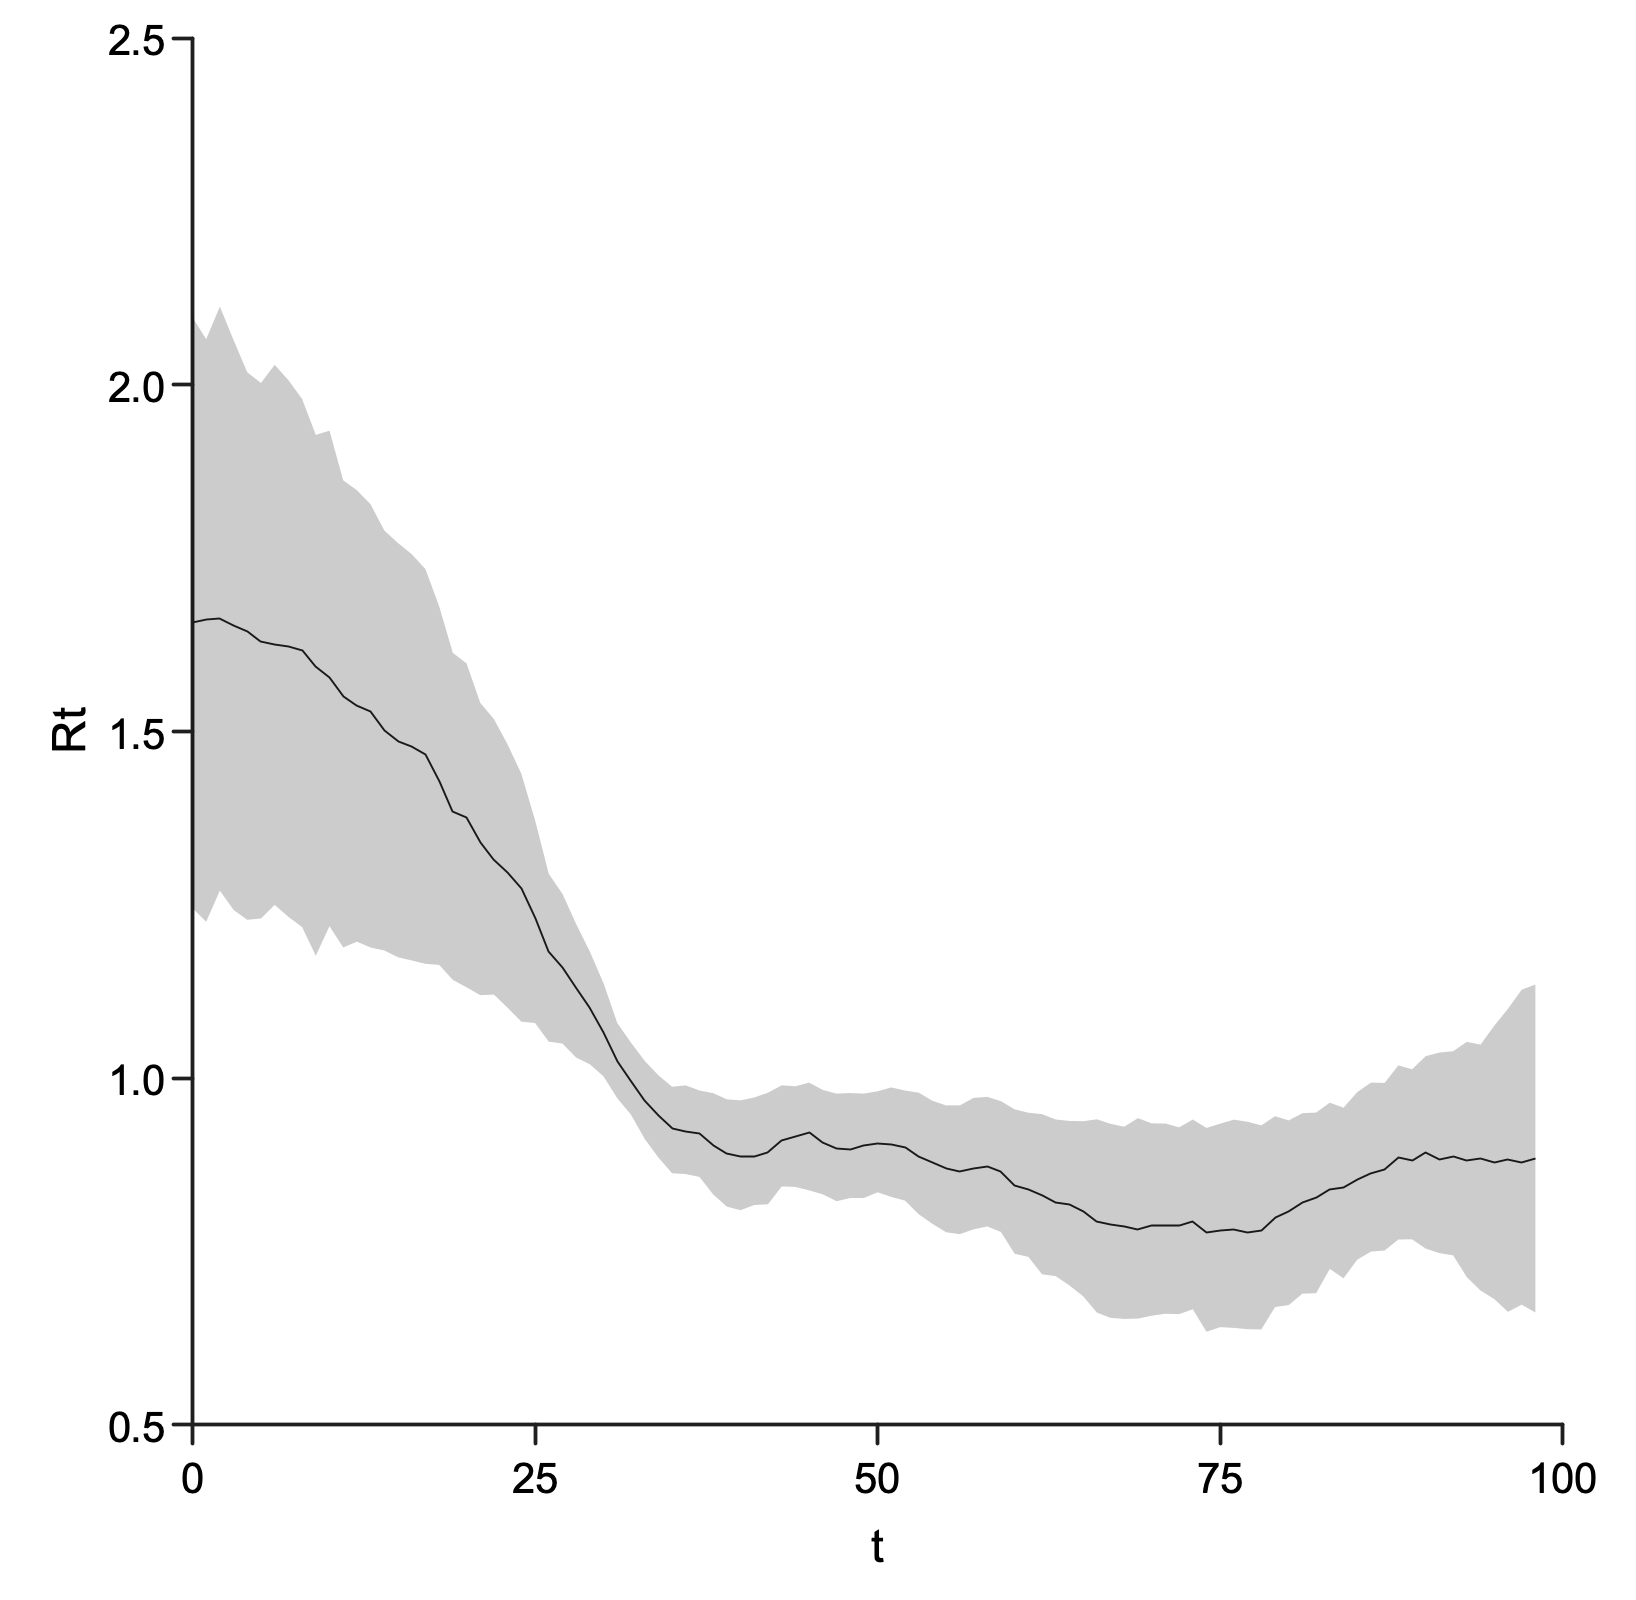

In [25]:
{{
    val RtsDistributionStats(means, hdpis) = countryStats("Italy")
    //  val RtsDistributionStats(means, hdpis) = countryStats("Austria")
    show("t", "Rt", line(means), shade(hdpis))
}}

In [26]:
def datesForCountry(country: String) = {
    countriesOnsetData.collect {
        case m if m("country") == country => m("date")
    }
}

defined function datesForCountry

In [27]:
def writeStatsToCsv(country: String, stats: RtsDistributionStats, csvWriter: CSVWriter): Unit = {
    val xs = stats.means.unzip._2 zip stats.hdpis.unzip._2
    val dates = datesForCountry(country)
//     assert(xs.size == dates.size, s"${xs.size} != ${dates.size}")
    (xs zip dates) foreach {
        case ((mean, (low90, high90)), date) => 
            csvWriter.writeRow(country :: date :: mean.toString :: low90.toString :: high90.toString :: Nil)
    }
}

defined function writeStatsToCsv

In [28]:
val csvWriter = CSVWriter.open(new File("data/rt-rainier.csv"))

csvWriter: CSVWriter = com.github.tototoshi.csv.CSVWriter@222d1b5a

In [29]:
csvWriter.writeRow(List("country", "date", "ML", "Low_90", "High_90"))

In [30]:
countryStats.toList.sortBy(_._1).foreach {
    case (country, stats) => writeStatsToCsv(country, stats, csvWriter)
}

In [31]:
csvWriter.close()

Changes from the original model:
* run the markov process with log(R_t) to ensure that it always stays positive
* use a Laplace transition to strongly regularize
* put a prior on the std dev of the transition, rather than fixing it
* put a prior on the serial interval rather than fixing it

## Original code from Avi Bryant

In [ ]:
val (model, rts) =  {
    val (xs, ys) = data.unzip

    val serialInterval = Normal(5,2).latent
    val logR0 = Normal(0, 1).latent
    val sigma = Exponential(10).latent
    val diffs = Laplace(0,sigma).latentVec(data.size)
    val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
    val likelihoods = Vec.from(xs).map{case (i, kt_prev) => 
        val lambda = ((logRts(i).exp - 1)/serialInterval).exp * kt_prev
        Poisson(lambda)
    }

    (Model.observe(ys, likelihoods), logRts.map(_.exp))
}

This seems to work best (and fastest) with a dead simple HMC(100) sampler, no mass matrix or path length adapation.

In [ ]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
}
val trace = model.sample(samplerConfig, 2)

In [ ]:
{{
    val rtForecasts = trace.predict(rts)
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val hdpis = 0.until(rts.size).map{i => (i, hdpi(rtForecasts.map(_(i))))}
    show("t", "Rt", line(means), shade(hdpis))
}}

In [ ]:
rts